In [1]:
import subprocess
import geojson
import firedrake
import icepack
import numpy as np
import math
import rasterio
import icepack.plot
from firedrake import assemble, Constant, inner, grad, dx
import matplotlib.pyplot as plt
import pickle
from icepack.statistics import (
    StatisticsProblem,
    MaximumProbabilityEstimator,
)
from rasterio.plot import show
import geojson
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import pandas as pd
from rasterio.crs import CRS
from rasterio.transform import from_origin
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


### Load extraction locations

In [2]:
with open("/home/sermilik/brunt_model/output_extraction_locations.pkl", "rb") as f1:
    extraction_locations = pickle.load(f1)

f1.close()

#perpendicular angles
west_angle = extraction_locations["west_angle"]
east_angle = extraction_locations["east_angle"]
#extraction points
w_n_x_2021 = extraction_locations["w_n_x_2021"]
w_n_y_2021 = extraction_locations["w_n_y_2021"]
w_s_x_2021 = extraction_locations["w_s_x_2021"]
w_s_y_2021 = extraction_locations["w_s_y_2021"]
e_n_x_2021 = extraction_locations["e_n_x_2021"]
e_n_y_2021 = extraction_locations["e_n_y_2021"]
e_s_x_2021 = extraction_locations["e_s_x_2021"]
e_s_y_2021 = extraction_locations["e_s_y_2021"]


with open("/home/sermilik/brunt_model/output_for_plotting.pkl", "rb") as f2:
    for_plotting = pickle.load(f2)
    
f2.close()

xmin = for_plotting["xmin"]
xmax = for_plotting["xmax"]
ymin = for_plotting["ymin"]
ymax = for_plotting["ymax"]
xmin_ew = for_plotting["xmin_ew"]
xmax_ew = for_plotting["xmax_ew"]
ymin_ew = for_plotting["ymin_ew"]
ymax_ew = for_plotting["ymax_ew"]
xcen_w = for_plotting["xcen_w"]
ycen_w = for_plotting["ycen_w"]
xcen_e = for_plotting["xcen_e"]
ycen_e = for_plotting["ycen_e"]
delta = for_plotting["delta"]
easting_w_n = for_plotting["easting_w_n"]
northing_w_n = for_plotting["northing_w_n"]
easting_w_s = for_plotting["easting_w_s"]
northing_w_s = for_plotting["northing_w_s"]
easting_e_n = for_plotting["easting_e_n"]
northing_e_n = for_plotting["northing_e_n"]
easting_e_s = for_plotting["easting_e_s"]
northing_e_s = for_plotting["northing_e_s"]

extent = (xmin, xmax, ymin, ymax)


### Geometry

In [3]:
outline_2021 = '/home/sermilik/brunt_model/d03_post_calving/brunt_HC_2021.geojson'
#Brunt_SWIT_HC_2020_cutoff_r.geojson'
#brunt_HC_2020.geojson'

with open(outline_2021,"r") as outline_file_2021:
    outline_2021 = geojson.load(outline_file_2021)
    
print(outline_2021["crs"]["properties"]["name"])

urn:ogc:def:crs:EPSG::3031


### Imagery

In [4]:
image_filename = icepack.datasets.fetch_mosaic_of_antarctica()
image_file = rasterio.open(image_filename, "r")

transform = image_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax, transform=transform
)

image = image_file.read(indexes=1, window=window, masked=True)

### Meshing

In [5]:
geometry_2021 = icepack.meshing.collection_to_geo(outline_2021)

with open("brunt_2021.geo", "w") as geo_file_2021:
    geo_file_2021.write(geometry_2021.get_code())
    
!gmsh -2 -format msh2 -v 2 -o brunt_2021.msh brunt_2021.geo

mesh_2021 = firedrake.Mesh("brunt_2021.msh")

### Input data - thickness

In [6]:
thickness_filename = '/home/sermilik/brunt_model/thickness_brunt_fullcalc.tif'
thickness = rasterio.open(thickness_filename,"r")

Q_2021 = firedrake.FunctionSpace(mesh_2021, "CG", 2)
h0_2021 = icepack.interpolate(thickness, Q_2021)

In [7]:
#smooth the DEM

h_2021 = h0_2021.copy(deepcopy=True)
α = firedrake.Constant(2e3)
J_2021 = 0.5 * (h_2021 - h0_2021)**2 * dx + 0.5 * α**2 * inner(grad(h_2021), grad(h_2021)) * dx
F_2021 = firedrake.derivative(J_2021, h_2021)
firedrake.solve(F_2021 == 0, h_2021)

### Input data - velocity/velocity error

In [8]:
# SNAP velocity
velocity_filename_vx_2021 = '/home/sermilik/brunt_model/d03_post_calving/Velocity_ps_20211125_20211207_vx_filt15.tif'
velocity_filename_vy_2021 = '/home/sermilik/brunt_model/d03_post_calving/Velocity_ps_20211125_20211207_vy_filt15.tif'

vx_2021 = rasterio.open(velocity_filename_vx_2021, "r")
vy_2021 = rasterio.open(velocity_filename_vy_2021, "r")

V_2021 = firedrake.VectorFunctionSpace(mesh_2021, "CG", 2)
u0_2021 = icepack.interpolate((vx_2021,vy_2021), V_2021)

In [9]:
velocity_filename_vx_2021_err = '/home/sermilik/brunt_model/Velocity_ps_error_5_0.tif'
velocity_filename_vy_2021_err = '/home/sermilik/brunt_model/Velocity_ps_error_5_0.tif'

stdx_2021 = rasterio.open(velocity_filename_vx_2021_err, "r")
stdy_2021 = rasterio.open(velocity_filename_vy_2021_err, "r")

σx_2021 = icepack.interpolate(stdx_2021, Q_2021)
σy_2021 = icepack.interpolate(stdy_2021, Q_2021)

### Plot inputs

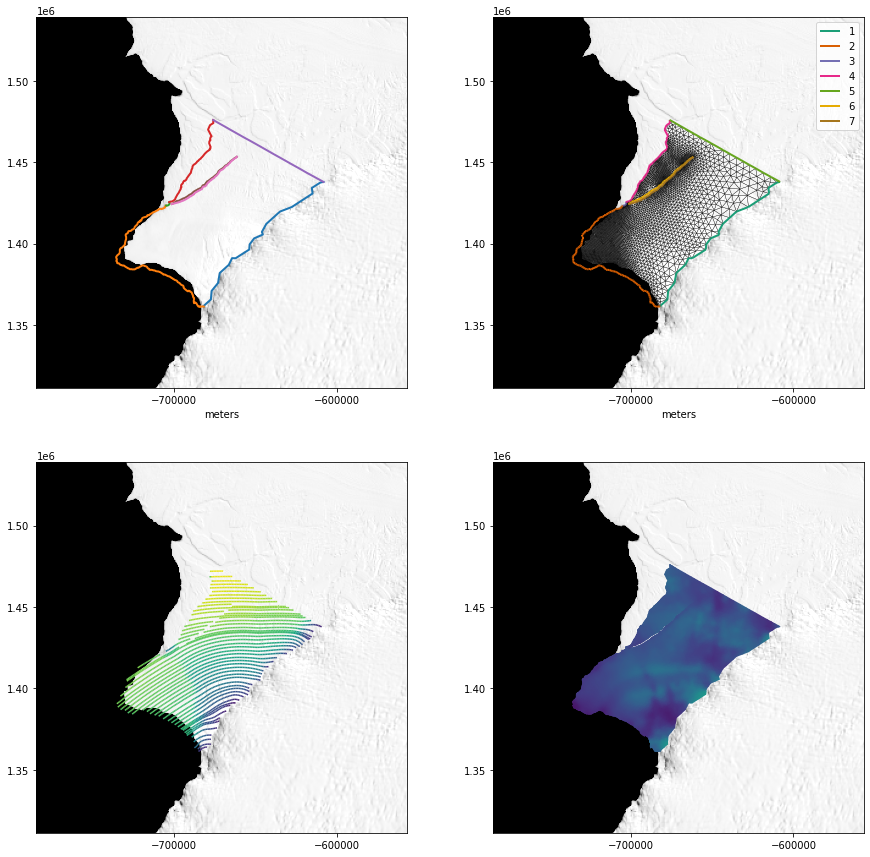

In [10]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

#OUTLINE
axes[0,0].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
for feature in outline_2021["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes[0,0].plot(xs[:, 0], xs[:, 1], linewidth=2)
axes[0,0].locator_params(axis='x',nbins=4)
axes[0,0].set_xlabel("meters");

#MESH
axes[0,1].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
axes[0,1].set_xlabel("meters")
kwargs = {
    "interior_kw": {"linewidth": 0.25},
    "boundary_kw": {"linewidth": 2},
}
icepack.plot.triplot(mesh_2021, axes=axes[0,1], **kwargs)
axes[0,1].locator_params(axis='x',nbins=4)
axes[0,1].legend();

#VELOCITY STREAMLINE
axes[1,0].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
streamlines = icepack.plot.streamplot(
    u0_2021, precision=1000, density=2000, axes=axes[1,0]
)
axes[1,0].locator_params(axis='x',nbins=4)
#fig.colorbar(streamlines, label="meters/year");

#THICKNESS RASTER
axes[1,1].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(h_2021, vmin=0, vmax=500, axes=axes[1,1])
axes[1,1].locator_params(axis='x',nbins=4)
#fig.colorbar(colors, label="thickness");

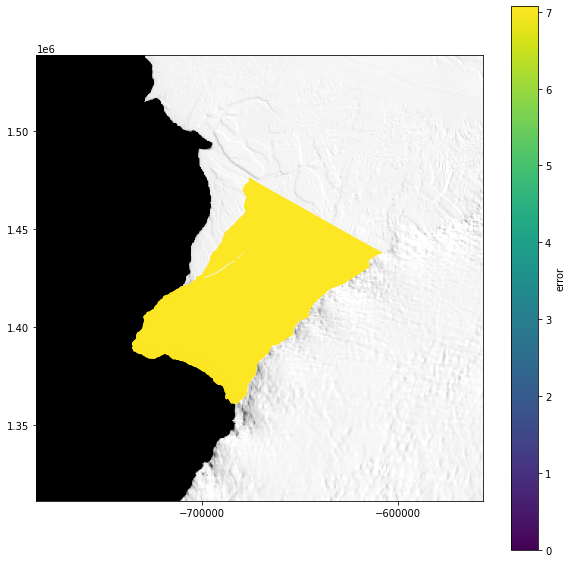

In [11]:
σ_2021 = firedrake.interpolate(firedrake.sqrt(σx_2021**2 + σy_2021**2), Q_2021)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(σ_2021, vmin=0, axes=ax)
ax.locator_params(axis='x',nbins=4)
fig.colorbar(colors, label="error");

In [12]:
T = Constant(253)
A0 = icepack.rate_factor(T)


def viscosity(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    θ = kwargs["log_fluidity"]

    A = A0 * firedrake.exp(θ)
    return icepack.models.viscosity.viscosity_depth_averaged(
        velocity=u, thickness=h, fluidity=A
    )


model = icepack.models.IceShelf(viscosity=viscosity)
opts = {
    "dirichlet_ids": [1, 3, 5],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "snes_type": "newtontr",
        "ksp_type": "gmres",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
solver = icepack.solvers.FlowSolver(model, **opts)

θ = firedrake.Function(Q_2021)
u = solver.diagnostic_solve(
    velocity=u0_2021,
    thickness=h_2021,
    log_fluidity=θ,
)

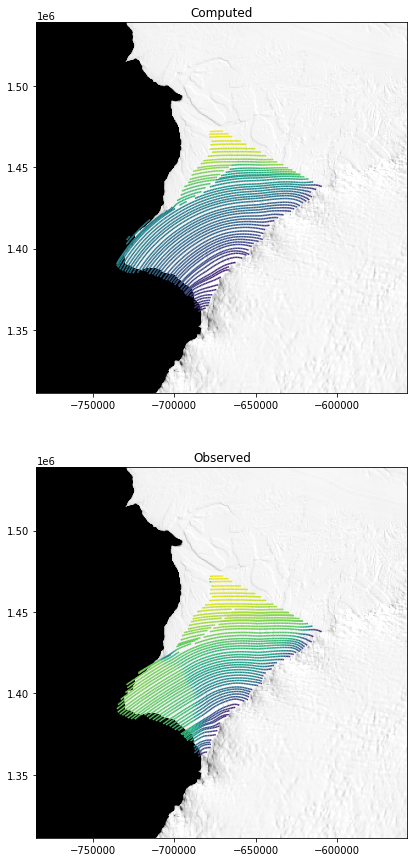

In [13]:
#fig, axes = subplots(ncols=2, sharex=True, sharey=True)
#for ax in axes:
#    ax.get_xaxis().set_visible(False)
#kwargs = {"precision": 1000, "density": 2500, "vmin": 0, "vmax": 750}
#axes[0].set_title("Computed")
#axes[1].set_title("Observed")
#icepack.plot.streamplot(u, axes=axes[0], **kwargs)
#icepack.plot.streamplot(u_obs, axes=axes[1], **kwargs);


fig, axes = plt.subplots(2,1, figsize=(7.5,15))
kwargs = {"precision": 1000, "density": 1500}
axes[0].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
axes[1].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
axes[0].set_title("Computed")
axes[1].set_title("Observed")
icepack.plot.streamplot(u, axes=axes[0], **kwargs)
icepack.plot.streamplot(u0_2021, axes=axes[1], **kwargs);




### Inferring the fluidity

There are four parts that go into an inverse problem:

* a physics model
* an initial guess for the parameter and state
* an error metric
* a smoothness metric

We already have the physics model and some initial guesses.
The physics are wrapped up in the Python function `simulation` defined below; we'll pass this function when we create the inverse problem.

In [14]:
def simulation(θ):
    return solver.diagnostic_solve(
        velocity=u0_2021,
        thickness=h_2021,
        log_fluidity=θ,
    )

In [15]:
area = Constant(assemble(Constant(1.0) * dx(mesh_2021)))

In [16]:
def loss_functional(u):
    δu = u - u0_2021
    return 0.5 / area * ((δu[0] / σx_2021)**2 + (δu[1] / σy_2021)**2) * dx


def regularization(θ):
    Θ = Constant(1.)
    L = Constant(7.5e3)
    return 0.5 / area * (L / Θ)**2 * inner(grad(θ), grad(θ)) * dx

In [17]:
problem = StatisticsProblem(
    simulation=simulation,
    loss_functional=loss_functional,
    regularization=regularization,
    controls=θ,
)

In [18]:
estimator = MaximumProbabilityEstimator(
    problem,
    gradient_tolerance=1e-4,
    step_tolerance=1e-2,
    max_iterations=500,
)
θ = estimator.solve()


Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     2.489155e+03   4.412908e-02                  4.412908e-02   
  1     2.489153e+03   4.412920e-02   4.412908e-02   1.103227e-01   3         2         0         1         2         
  2     2.489148e+03   4.412949e-02   1.103227e-01   2.758068e-01   4         3         0         1         2         
  3     2.489136e+03   4.413021e-02   2.758068e-01   6.895169e-01   5         4         0         1         2         
  4     2.489106e+03   4.413201e-02   6.895169e-01   1.723792e+00   6         5         0         1         2         
  5     2.489030e+03   4.413652e-02   1.723792e+00   4.309481e+00   7         6         0         1         2         
  6     2.488839e+03   4.414781e-02   4.309481e+00   1.077370e+01   8         7         0         1         2         
  7     2.488364e+03   4.417614e-02   1.077370e+01   2.693425e+0

  68    2.790551e+01   8.972669e-04   8.003517e+02   2.000879e+03   70        60        0         7         3         
  69    2.743321e+01   7.734156e-04   2.000879e+03   5.002198e+03   71        61        0         9         3         
  70    2.675874e+01   2.404557e-03   5.002198e+03   5.002198e+03   72        62        0         13        3         
  71    2.574518e+01   7.820947e-04   5.002198e+03   1.250549e+04   73        63        0         19        3         
  72    2.499215e+01   1.941593e-03   7.073862e+03   1.250549e+04   74        64        0         20        1         
  73    2.409566e+01   7.491223e-04   3.204334e+03   1.250549e+04   75        65        0         20        1         
  74    2.409566e+01   7.491223e-04   7.231991e+03   7.815934e+02   76        65        2         20        1         
  75    2.388485e+01   4.527207e-04   7.815934e+02   1.953984e+03   77        66        0         8         3         
  76    2.365782e+01   4.774169e-03   1.953984e+

  137   1.501785e+01   1.238565e-04   7.522169e+02   6.465189e+16   139       127       0         20        1         
  138   1.499939e+01   1.589064e-04   7.218105e+02   6.465189e+16   140       128       0         20        1         
  139   1.498285e+01   1.198006e-04   7.250227e+02   6.465189e+16   141       129       0         20        1         
  140   1.496550e+01   1.551578e-04   7.037845e+02   6.465189e+16   142       130       0         20        1         
  141   1.494979e+01   1.156860e-04   6.998794e+02   6.465189e+16   143       131       0         20        1         
  142   1.493342e+01   1.682540e-04   6.880269e+02   6.465189e+16   144       132       0         20        1         
  143   1.491842e+01   1.270428e-04   6.778293e+02   6.465189e+16   145       133       0         20        1         
  144   1.490296e+01   1.473286e-04   6.703338e+02   6.465189e+16   146       134       0         20        1         
  145   1.488868e+01   1.099814e-04   6.546519e+

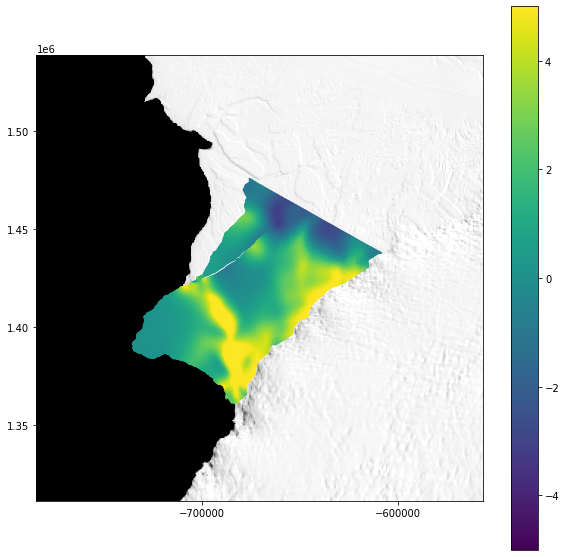

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(θ, vmin=-5, vmax=+5, axes=ax)
ax.locator_params(axis='x',nbins=4)
fig.colorbar(colors);

In [20]:
u_2021 = simulation(θ)

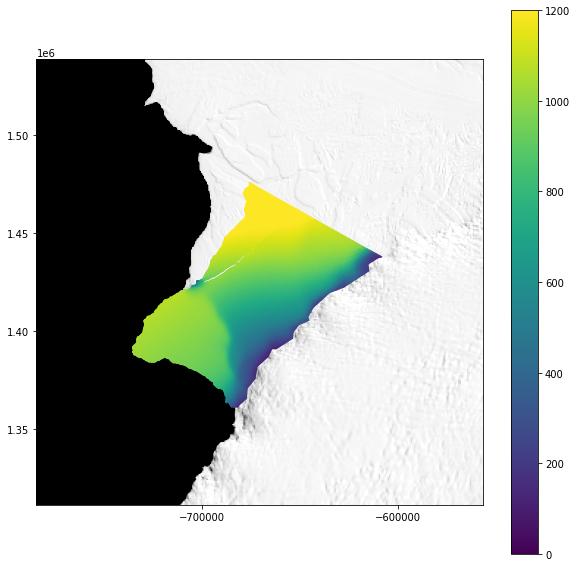

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(u_2021, vmin=0, vmax=1200, axes=ax)
ax.locator_params(axis='x',nbins=4)
fig.colorbar(colors);

### Make tif

In [22]:
shelf_outline = [
( -608237.9, 1437866.1 ), ( -610183.2, 1437503.2 ), ( -615426.3, 1434163.1 ), ( -614941.4, 1430772.5 ), ( -627707.1, 1422470.6 ), ( -634967.3, 1419676.9 ), ( -643370.1, 1412098.9 ), ( -646085.9, 1407167.4 ), ( -645495.2, 1405566.9 ), ( -650852.7, 1403200.7 ), ( -653614.5, 1399491.6 ), ( -653840.4, 1396359.7 ), ( -662256.4, 1391003.6 ), ( -664387.2, 1391078.8 ), ( -666392.8, 1386979.7 ), ( -671966.0, 1381936.3 ), ( -673018.5, 1375798.3 ), ( -676963.7, 1370930.0 ), ( -677400.2, 1365695.3 ), ( -681400.5, 1362119.1 ), ( -681770.4, 1361316.1 ),
( -681770.4, 1361316.1 ), ( -682319.4, 1361436.9 ), ( -683477.0, 1361271.6 ), ( -683973.1, 1361177.1 ), ( -684091.2, 1361566.9 ), ( -684433.7, 1361413.3 ), ( -685024.3, 1361295.2 ), ( -685520.4, 1361956.7 ), ( -686370.9, 1363445.0 ), ( -687150.5, 1363929.3 ), ( -687470.2, 1364047.2 ), ( -687525.0, 1363499.1 ), ( -687726.0, 1363398.7 ), ( -687890.4, 1364129.4 ), ( -687917.8, 1364997.2 ), ( -687735.1, 1365846.8 ), ( -687716.9, 1366285.2 ), ( -687817.3, 1366742.0 ), ( -688137.1, 1366833.3 ), ( -688374.6, 1367555.0 ), ( -688454.7, 1368393.9 ), ( -688729.8, 1368683.5 ), ( -689193.2, 1370001.1 ), ( -690293.6, 1370638.3 ), ( -690366.0, 1370898.9 ), ( -691090.0, 1371072.6 ), ( -691466.5, 1370696.2 ), ( -692187.7, 1371119.1 ), ( -693504.9, 1372198.3 ), ( -694139.7, 1372960.0 ), ( -694139.7, 1373515.5 ), ( -694409.6, 1374198.0 ), ( -695123.7, 1374467.8 ), ( -695901.4, 1374943.9 ), ( -696679.0, 1375816.8 ), ( -697710.6, 1376324.6 ), ( -698297.9, 1377213.4 ), ( -699012.0, 1377546.7 ), ( -699631.0, 1377673.6 ), ( -700107.1, 1378133.9 ), ( -700694.3, 1378340.2 ), ( -701041.5, 1378782.6 ), ( -701623.2, 1378886.5 ), ( -702038.6, 1379405.8 ), ( -702495.6, 1379572.0 ), ( -702724.1, 1379800.5 ), ( -703742.0, 1380008.2 ), ( -704967.6, 1380610.7 ), ( -705611.6, 1380984.6 ), ( -706525.6, 1380963.8 ), ( -706691.8, 1381254.6 ), ( -707792.7, 1381960.9 ), ( -708478.2, 1382459.4 ), ( -708956.0, 1382584.1 ), ( -709475.3, 1382874.9 ), ( -710347.8, 1382937.2 ), ( -711178.7, 1383103.4 ), ( -711961.8, 1383522.7 ), ( -712719.7, 1383568.2 ), ( -713053.1, 1383734.9 ), ( -713962.5, 1383931.9 ), ( -714432.4, 1383856.1 ), ( -715053.8, 1383916.8 ), ( -715296.3, 1384386.6 ), ( -716160.2, 1384917.1 ), ( -716675.6, 1385720.4 ), ( -717342.4, 1386099.3 ), ( -718160.9, 1386266.0 ), ( -718585.3, 1386614.6 ), ( -719295.2, 1386626.5 ), ( -719838.5, 1386463.5 ), ( -720083.0, 1386191.9 ), ( -720762.1, 1385920.2 ), ( -721875.9, 1385146.0 ), ( -722460.0, 1385186.7 ), ( -724171.4, 1384181.6 ), ( -725013.5, 1384168.0 ), ( -725719.8, 1384168.0 ), ( -726344.6, 1384344.6 ), ( -727078.1, 1384236.0 ), ( -727990.7, 1384832.1 ), ( -728467.0, 1384882.7 ), ( -728791.4, 1385217.2 ), ( -729582.0, 1385632.8 ), ( -729926.6, 1385916.6 ), ( -730169.9, 1386007.8 ), ( -730646.3, 1386443.7 ), ( -731213.9, 1386595.7 ), ( -731436.9, 1386524.8 ), ( -731771.4, 1386575.4 ), ( -732399.8, 1386859.3 ), ( -732866.1, 1386950.5 ), ( -733326.5, 1387303.8 ), ( -733766.5, 1387764.8 ), ( -734066.9, 1387911.5 ), ( -734870.2, 1387953.4 ), ( -734919.1, 1388211.9 ), ( -734919.1, 1388498.3 ), ( -735058.8, 1388854.5 ), ( -735429.0, 1389266.6 ), ( -735456.9, 1389462.2 ), ( -735226.4, 1389832.4 ), ( -735128.6, 1390558.9 ), ( -735373.1, 1390957.1 ), ( -735577.9, 1391654.8 ), ( -735512.3, 1391898.3 ), ( -734875.6, 1392806.6 ), ( -733976.7, 1393508.8 ), ( -733480.4, 1394080.0 ), ( -733293.2, 1394847.8 ), ( -733332.3, 1395423.0 ), ( -733325.9, 1396193.1 ), ( -733133.4, 1396655.2 ), ( -732748.3, 1397187.8 ), ( -732414.6, 1397386.7 ), ( -732061.6, 1397476.6 ), ( -731394.2, 1398156.8 ), ( -730788.3, 1398745.7 ), ( -730232.0, 1399321.8 ), ( -730073.1, 1400613.1 ), ( -729795.0, 1401765.4 ), ( -729437.4, 1402798.5 ), ( -729437.4, 1404169.3 ), ( -729715.5, 1404864.6 ), ( -729715.5, 1405500.4 ), ( -729238.7, 1406076.5 ), ( -728523.5, 1406314.9 ), ( -727972.1, 1407626.1 ), ( -727104.5, 1407723.9 ), ( -726408.1, 1407919.4 ), ( -726053.7, 1408273.7 ), ( -725711.6, 1408615.9 ), ( -724990.6, 1408835.8 ), ( -724391.9, 1409361.2 ), ( -724196.4, 1410167.7 ), ( -723715.7, 1410770.9 ), ( -723097.4, 1411298.8 ), ( -722584.7, 1411811.5 ), ( -722373.5, 1412610.8 ), ( -721740.1, 1413364.9 ), ( -721167.0, 1413289.5 ), ( -721061.5, 1413953.0 ), ( -720684.4, 1414164.2 ), ( -720156.6, 1414058.6 ), ( -719960.5, 1414737.3 ), ( -719493.0, 1415717.5 ), ( -718904.9, 1416004.1 ), ( -718105.6, 1416260.4 ), ( -717095.1, 1416501.7 ), ( -716371.3, 1416984.3 ), ( -716341.1, 1417482.0 ), ( -715210.0, 1417451.8 ), ( -714908.4, 1417934.4 ), ( -713596.3, 1418688.5 ), ( -713065.0, 1419127.2 ), ( -711752.0, 1419652.4 ), ( -710618.7, 1420246.6 ), ( -709734.2, 1420688.9 ), ( -709457.7, 1421103.5 ), ( -708697.6, 1421393.8 ), ( -708153.6, 1421371.3 ), ( -707633.1, 1421232.6 ), ( -707017.3, 1421458.1 ), ( -706375.5, 1421770.3 ), ( -705667.5, 1422105.5 ), ( -705557.1, 1422625.8 ), ( -705478.9, 1423005.4 ), ( -704798.0, 1423094.7 ), ( -704866.5, 1423373.0 ),
( -704866.5, 1423373.0 ), ( -704464.1, 1423373.4 ), ( -704260.1, 1423364.9 ), ( -703979.6, 1423398.9 ), ( -703682.0, 1423517.9 ), ( -703446.2, 1423675.2 ), ( -703240.0, 1423823.9 ), ( -703078.5, 1424002.5 ), ( -702877.0, 1424290.1 ), ( -702763.9, 1424606.0 ), ( -702755.4, 1424988.6 ), ( -702823.4, 1425252.1 ), ( -703010.5, 1425447.6 ),
( -703010.5, 1425447.6 ), ( -702539.9, 1425648.2 ), ( -702204.9, 1425799.9 ), ( -701408.5, 1425837.9 ), ( -701041.9, 1426008.5 ), ( -700416.1, 1426324.6 ), ( -700100.1, 1426609.0 ), ( -699562.8, 1426956.6 ), ( -699275.2, 1427363.7 ), ( -699207.0, 1427786.4 ), ( -697966.0, 1430118.5 ), ( -697106.8, 1431291.3 ), ( -696547.7, 1432477.8 ), ( -696111.3, 1433187.0 ), ( -695879.4, 1433596.1 ), ( -695934.0, 1434264.4 ), ( -695443.0, 1434755.3 ), ( -695716.5, 1435556.2 ), ( -695500.6, 1436184.4 ), ( -694636.8, 1437028.5 ), ( -694381.7, 1437794.1 ), ( -693812.4, 1438598.9 ), ( -693478.7, 1438461.5 ), ( -692457.9, 1439286.0 ), ( -692222.3, 1440090.8 ), ( -691044.5, 1441739.7 ), ( -690004.2, 1443133.4 ), ( -689749.0, 1443349.4 ), ( -689277.8, 1445351.6 ), ( -688787.1, 1446333.1 ), ( -688649.7, 1447471.7 ), ( -687966.9, 1448420.7 ), ( -686955.4, 1449058.9 ), ( -686100.4, 1449938.0 ), ( -685919.8, 1450287.2 ), ( -685727.1, 1450491.9 ), ( -685221.4, 1450768.8 ), ( -684751.7, 1451322.8 ), ( -684450.7, 1451635.8 ), ( -683692.1, 1452153.6 ), ( -683186.3, 1452840.0 ), ( -682825.1, 1453104.9 ), ( -682054.4, 1453996.0 ), ( -681162.0, 1455163.1 ), ( -679717.2, 1456553.6 ), ( -678110.0, 1457637.1 ), ( -678110.0, 1458106.7 ), ( -677694.7, 1458395.6 ), ( -677766.9, 1458811.0 ), ( -677550.2, 1459352.7 ), ( -678435.1, 1461537.9 ), ( -678326.7, 1462892.3 ), ( -677766.9, 1463289.6 ), ( -677676.6, 1463723.0 ), ( -677911.4, 1463993.9 ), ( -677604.4, 1465330.2 ), ( -676972.3, 1465835.9 ), ( -679136.3, 1470021.8 ), ( -677929.4, 1472737.2 ), ( -675892.8, 1474019.6 ), ( -675987.2, 1475907.6 ), ( -675983.8, 1475926.3 ),
( -675983.8, 1475926.3 ), ( -672193.0, 1473752.1 ), ( -668783.9, 1471832.9 ), ( -664541.5, 1469408.7 ), ( -661006.2, 1467413.8 ), ( -657285.9, 1465304.9 ), ( -653673.1, 1463345.5 ), ( -650488.9, 1461569.7 ), ( -643122.6, 1457399.5 ), ( -639355.2, 1455235.3 ), ( -635026.7, 1452830.6 ), ( -630618.1, 1450345.7 ), ( -627091.2, 1448341.8 ), ( -623163.5, 1446177.6 ), ( -618434.2, 1443452.2 ), ( -613705.0, 1440887.2 ), ( -609617.0, 1438642.8 ), ( -608237.9, 1437866.1 ), 
]

shelf_poly = Polygon(shelf_outline)


rift_outline = [
( -701449.6, 1424307.4 ), ( -700522.3, 1424680.7 ), ( -699149.3, 1425608.1 ), ( -698161.8, 1426306.6 ), ( -697643.9, 1426150.0 ), ( -696668.4, 1426559.5 ), ( -694235.6, 1427812.0 ), ( -694018.8, 1427715.7 ), ( -693255.5, 1428139.7 ), ( -691605.8, 1429157.1 ), ( -690620.9, 1429957.3 ), ( -689394.9, 1430506.9 ), ( -687915.2, 1431902.0 ), ( -685399.7, 1433339.5 ), ( -683793.1, 1434121.6 ), ( -683053.3, 1434502.1 ), ( -682503.7, 1435664.7 ), ( -682059.8, 1435918.4 ), ( -681531.3, 1435897.2 ), ( -681045.1, 1436362.3 ), ( -680741.9, 1436807.8 ), ( -680472.7, 1436936.5 ), ( -680449.2, 1437252.6 ), ( -680016.1, 1437685.8 ), ( -679910.7, 1438037.0 ), ( -679664.9, 1438259.5 ), ( -678740.0, 1438634.1 ), ( -678377.1, 1439067.3 ), ( -677662.9, 1439559.0 ), ( -677253.1, 1439699.5 ), ( -677019.0, 1440144.4 ), ( -676340.0, 1440507.3 ), ( -676070.7, 1440753.1 ), ( -675508.8, 1440999.0 ), ( -675169.2, 1441596.1 ), ( -674250.5, 1442169.8 ), ( -673236.1, 1443261.1 ), ( -672713.5, 1444460.0 ), ( -671622.2, 1445382.2 ), ( -670515.5, 1446058.5 ), ( -669741.6, 1446596.7 ), ( -668969.1, 1447402.8 ), ( -668608.0, 1447839.4 ), ( -668112.6, 1448141.7 ), ( -667684.3, 1448175.3 ), ( -667306.4, 1448410.4 ), ( -667113.3, 1448805.1 ), ( -666785.8, 1449183.0 ), ( -666088.9, 1449636.4 ), ( -665622.9, 1450146.0 ), ( -665238.7, 1450685.8 ), ( -664733.0, 1451045.7 ), ( -664314.7, 1451269.4 ), ( -662849.3, 1452454.5 ), ( -662621.3, 1452641.0 ), ( -662227.6, 1452744.6 ), ( -661481.6, 1453314.5 ),
( -661481.6, 1453314.5 ), ( -661730.2, 1452983.0 ), ( -662994.3, 1452164.4 ), ( -664279.2, 1451086.8 ), ( -665004.5, 1450599.8 ), ( -665553.7, 1449760.5 ), ( -666082.1, 1449325.3 ), ( -666937.2, 1448441.1 ), ( -667152.3, 1448118.4 ), ( -667743.8, 1447858.5 ), ( -668299.5, 1447518.0 ), ( -668864.1, 1446854.7 ), ( -669222.6, 1446406.6 ), ( -670047.1, 1445644.8 ), ( -670611.8, 1445375.9 ), ( -671441.3, 1444938.0 ), ( -672067.0, 1444415.1 ), ( -672197.7, 1444013.5 ), ( -672561.9, 1443649.3 ), ( -672720.7, 1443163.7 ), ( -673600.5, 1442124.2 ), ( -674125.0, 1441521.1 ), ( -674938.0, 1441057.8 ), ( -675147.8, 1440655.7 ), ( -675539.4, 1440154.8 ), ( -676536.7, 1439675.2 ), ( -676932.6, 1439370.7 ), ( -676978.3, 1439104.2 ), ( -677686.3, 1438715.9 ), ( -678318.2, 1438198.2 ), ( -678531.4, 1437886.1 ), ( -679079.5, 1437482.6 ), ( -680126.7, 1436102.9 ), ( -680508.8, 1435473.0 ), ( -681045.8, 1435080.6 ), ( -681686.0, 1435070.2 ), ( -682223.0, 1434853.4 ), ( -682574.1, 1434285.4 ), ( -682729.0, 1433645.2 ), ( -683944.5, 1432951.8 ), ( -685076.3, 1432385.9 ), ( -685942.5, 1431877.7 ), ( -687189.8, 1431103.9 ), ( -687929.0, 1430445.6 ), ( -687788.6, 1430311.2 ), ( -688732.2, 1429684.6 ), ( -689464.5, 1429261.9 ), ( -690107.4, 1428948.3 ), ( -690555.8, 1428568.8 ), ( -691274.4, 1428120.4 ), ( -692809.3, 1427198.4 ), ( -694011.7, 1426572.2 ), ( -694604.5, 1426296.6 ), ( -695372.7, 1426104.6 ), ( -696616.8, 1425520.1 ), ( -698743.5, 1424945.5 ), ( -700505.0, 1424486.0 ), ( -701366.4, 1424288.6 ), ( -701449.6, 1424307.4 )
]

rift_poly = Polygon(rift_outline)

In [23]:
tifxmin = -750000
tifxmax = -600000
tifymin = 1350000
tifymax = 1500000
tifres = 100 #250

tifxlen = (tifxmax-tifxmin)/tifres
tifylen = (tifymax-tifymin)/tifres

tifx = np.linspace(tifxmin+(tifres/2),tifxmax-(tifres/2),num=int(tifxlen))
tify = np.linspace(tifymax-(tifres/2),tifymin+(tifres/2),num=int(tifylen))


In [24]:
tras = np.zeros((int(tifxlen),int(tifylen)))
vras = np.zeros((int(tifxlen),int(tifylen)))
vxras = np.zeros((int(tifxlen),int(tifylen)))
vyras = np.zeros((int(tifxlen),int(tifylen)))

for tx in range(0,int(tifxlen)):
    for ty in range(0,int(tifylen)):
        on_shelf = shelf_poly.contains(Point(tifx[tx],tify[ty]))
        in_rift = rift_poly.contains(Point(tifx[tx],tify[ty]))
        
        if (on_shelf==True) & (in_rift==False):
            tras[ty,tx] = θ((tifx[tx],tify[ty]))
            vras[ty,tx] = np.sqrt(u_2021((tifx[tx],tify[ty]))[0] **2 + u_2021((tifx[tx],tify[ty]))[1] **2)
            vxras[ty,tx] = u_2021((tifx[tx],tify[ty]))[0]
            vyras[ty,tx] = u_2021((tifx[tx],tify[ty]))[1]
        else:
            tras[ty,tx] = np.nan
            vras[ty,tx] = np.nan
            vxras[ty,tx] = np.nan
            vyras[ty,tx] = np.nan

In [25]:
driver = "GTiff"
dim = vras.shape
height = dim[0]
width = dim[1]
count = 1
dtype = vras.dtype

print(height,width)
print(dtype)


1500 1500
float64


In [26]:
crs = CRS.from_epsg(3031)

transform = from_origin(tifxmin,tifymax,tifres,tifres)

transform

Affine(100.0, 0.0, -750000.0,
       0.0, -100.0, 1500000.0)

In [27]:
with rasterio.open("./fluidity_post_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(tras,1)

In [28]:
with rasterio.open("./model_velocity_post_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(vras,1)

In [29]:
with rasterio.open("./model_velocity_vx_post_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(vxras,1)

In [30]:
with rasterio.open("./model_velocity_vy_post_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(vyras,1)

### Make fig

Ground track angles
western pair: -34.2 deg
western pair: -0.6 rad
eastern pair: -37.3 deg
western pair: -0.65 rad

western pair, seaward
v east: -944.7m/yr, v_north: -244.8 m/yr, v_total: 975.9 m/yr
angle : -104.5 deg
offset: 70.4 deg

western pair, landward
v east: -921.7m/yr, v_north: -394.1 m/yr, v_total: 1002.4 m/yr
angle : -113.2 deg
offset: 79.0 deg

eastern pair, seaward
v east: -1095.2m/yr, v_north: -72.8 m/yr, v_total: 1097.7 m/yr
angle : -93.8 deg
offset: 56.5 deg

eastern pair, landward
v east: -1095.0m/yr, v_north: -182.8 m/yr, v_total: 1110.2 m/yr
angle : -99.5 deg
offset: 62.2 deg

------------------------------

west,  seaward v_total: 975.9 m/yr
west, landward v_total: 1002.4 m/yr
east,  seaward v_total: 1097.7 m/yr
east, landward v_total: 1110.2 m/yr

west,   seaward v_perp: 327.9 m/yr
west,  landward v_perp: 191.4 m/yr
east,   seaward v_perp: 605.2 m/yr
east,  landward v_perp: 517.6 m/yr

Western opening rate: 136.5 m/yr
Eastern opening rate: 87.6 m/yr


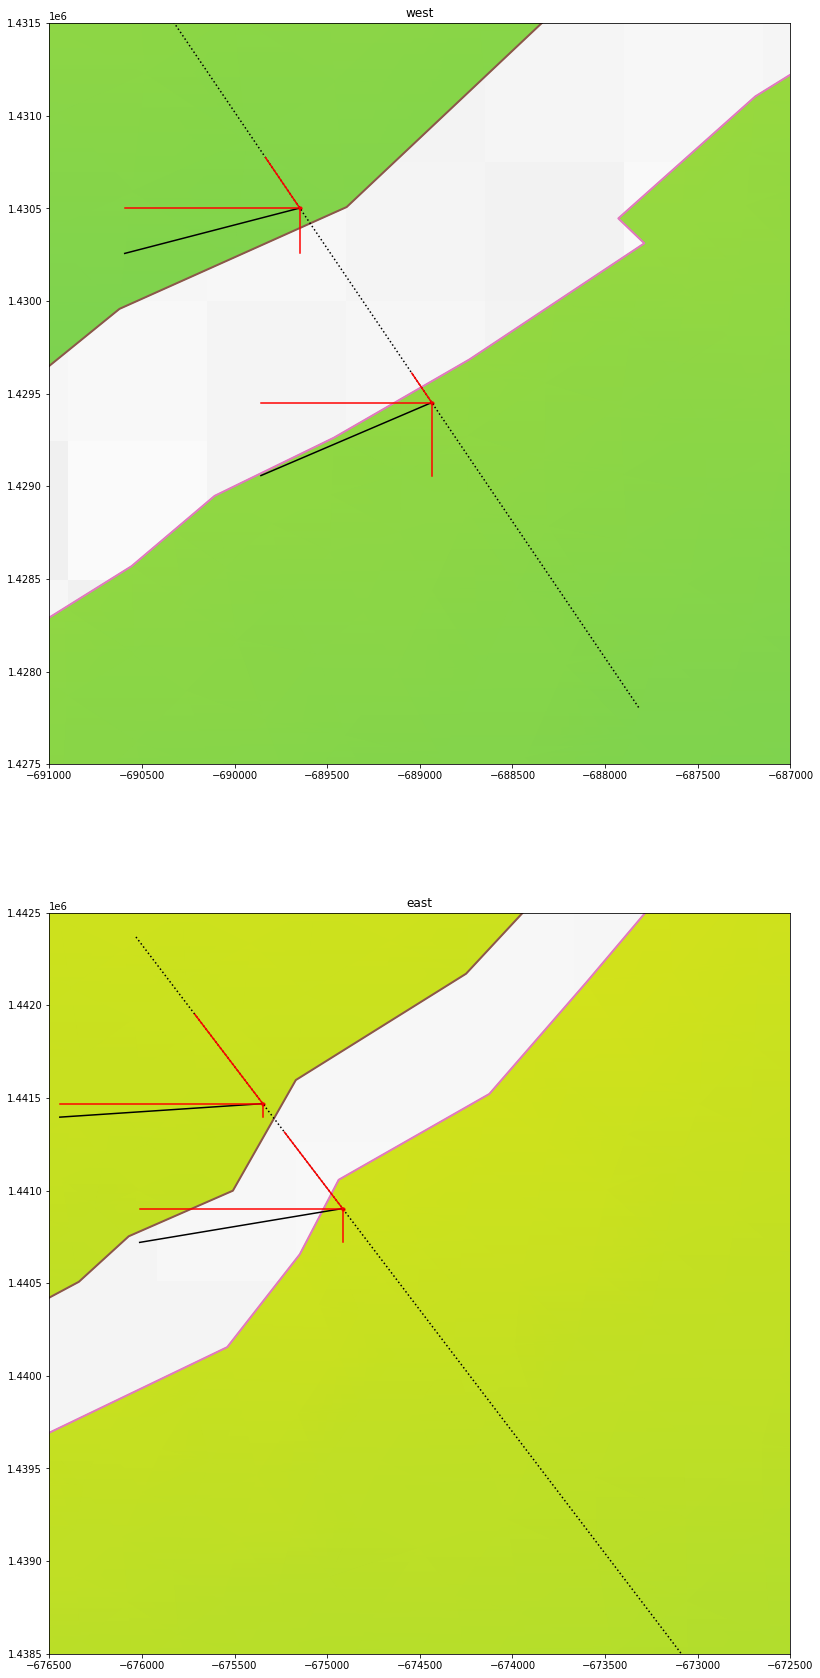

In [31]:
fig, axes = plt.subplots(2,1, figsize=(15,30))

axes[0].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(u_2021, vmin=0, vmax=1200, axes=axes[0])

axes[1].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(u_2021, vmin=0, vmax=1200, axes=axes[1])

for feature in outline_2021["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes[0].plot(xs[:, 0], xs[:, 1], linewidth=2)
        
for feature in outline_2021["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes[1].plot(xs[:, 0], xs[:, 1], linewidth=2)
        
axes[0].plot([easting_w_n,easting_w_s],[northing_w_n,northing_w_s],'k:')
axes[1].plot([easting_e_n,easting_e_s],[northing_e_n,northing_e_s],'k:')        
        
axes[0].scatter(w_n_x_2021,w_n_y_2021,s=10,c='r')
axes[0].scatter(w_s_x_2021,w_s_y_2021,s=10,c='r')
axes[1].scatter(e_n_x_2021,e_n_y_2021,s=10,c='r')
axes[1].scatter(e_s_x_2021,e_s_y_2021,s=10,c='r')

#model
vw_n_2021 = u_2021((w_n_x_2021,w_n_y_2021))
vw_s_2021 = u_2021((w_s_x_2021,w_s_y_2021))
ve_n_2021 = u_2021((e_n_x_2021,e_n_y_2021))
ve_s_2021 = u_2021((e_s_x_2021,e_s_y_2021))

#FT
ft_vw_n_2021 = u0_2021((w_n_x_2021,w_n_y_2021))
ft_vw_s_2021 = u0_2021((w_s_x_2021,w_s_y_2021))
ft_ve_n_2021 = u0_2021((e_n_x_2021,e_n_y_2021))
ft_ve_s_2021 = u0_2021((e_s_x_2021,e_s_y_2021))

#model
vw_n_2021_tot = np.sqrt((vw_n_2021[0]**2)+(vw_n_2021[1]**2))
vw_s_2021_tot = np.sqrt((vw_s_2021[0]**2)+(vw_s_2021[1]**2))
ve_n_2021_tot = np.sqrt((ve_n_2021[0]**2)+(ve_n_2021[1]**2))
ve_s_2021_tot = np.sqrt((ve_s_2021[0]**2)+(ve_s_2021[1]**2))

#ft
ft_vw_n_2021_tot = np.sqrt((ft_vw_n_2021[0]**2)+(ft_vw_n_2021[1]**2))
ft_vw_s_2021_tot = np.sqrt((ft_vw_s_2021[0]**2)+(ft_vw_s_2021[1]**2))
ft_ve_n_2021_tot = np.sqrt((ft_ve_n_2021[0]**2)+(ft_ve_n_2021[1]**2))
ft_ve_s_2021_tot = np.sqrt((ft_ve_s_2021[0]**2)+(ft_ve_s_2021[1]**2))

#axes.arrow(w_n_x_2021,w_n_y_2021,vw_n_2021[0],vw_n_2021[1],head_width=150,color='k')
#axes.arrow(w_s_x_2021,w_s_y_2021,vw_s_2021[0],vw_s_2021[1],head_width=150,color='k')
#axes.arrow(e_n_x_2021,e_n_y_2021,ve_n_2021[0],ve_n_2021[1],head_width=150,color='k')
#axes.arrow(e_s_x_2021,e_s_y_2021,ve_s_2021[0],ve_s_2021[1],head_width=150,color='k')

axes[0].plot([w_n_x_2021,w_n_x_2021+vw_n_2021[0]],[w_n_y_2021,w_n_y_2021+vw_n_2021[1]],color='k')
axes[0].plot([w_s_x_2021,w_s_x_2021+vw_s_2021[0]],[w_s_y_2021,w_s_y_2021+vw_s_2021[1]],color='k')
axes[1].plot([e_n_x_2021,e_n_x_2021+ve_n_2021[0]],[e_n_y_2021,e_n_y_2021+ve_n_2021[1]],color='k')
axes[1].plot([e_s_x_2021,e_s_x_2021+ve_s_2021[0]],[e_s_y_2021,e_s_y_2021+ve_s_2021[1]],color='k')

axes[0].plot([w_n_x_2021,w_n_x_2021+0],[w_n_y_2021,w_n_y_2021+vw_n_2021[1]],color='r')
axes[0].plot([w_s_x_2021,w_s_x_2021+0],[w_s_y_2021,w_s_y_2021+vw_s_2021[1]],color='r')
axes[1].plot([e_n_x_2021,e_n_x_2021+0],[e_n_y_2021,e_n_y_2021+ve_n_2021[1]],color='r')
axes[1].plot([e_s_x_2021,e_s_x_2021+0],[e_s_y_2021,e_s_y_2021+ve_s_2021[1]],color='r')

axes[0].plot([w_n_x_2021,w_n_x_2021+vw_n_2021[0]],[w_n_y_2021,w_n_y_2021+0],color='r')
axes[0].plot([w_s_x_2021,w_s_x_2021+vw_s_2021[0]],[w_s_y_2021,w_s_y_2021+0],color='r')
axes[1].plot([e_n_x_2021,e_n_x_2021+ve_n_2021[0]],[e_n_y_2021,e_n_y_2021+0],color='r')
axes[1].plot([e_s_x_2021,e_s_x_2021+ve_s_2021[0]],[e_s_y_2021,e_s_y_2021+0],color='r')

#model
vw_n_2021_angle = (math.atan(vw_n_2021[1]/vw_n_2021[0]))
vw_s_2021_angle = (math.atan(vw_s_2021[1]/vw_s_2021[0]))
ve_n_2021_angle = (math.atan(ve_n_2021[1]/ve_n_2021[0]))
ve_s_2021_angle = (math.atan(ve_s_2021[1]/ve_s_2021[0]))

#ft
ft_vw_n_2021_angle = (math.atan(ft_vw_n_2021[1]/ft_vw_n_2021[0]))
ft_vw_s_2021_angle = (math.atan(ft_vw_s_2021[1]/ft_vw_s_2021[0]))
ft_ve_n_2021_angle = (math.atan(ft_ve_n_2021[1]/ft_ve_n_2021[0]))
ft_ve_s_2021_angle = (math.atan(ft_ve_s_2021[1]/ft_ve_s_2021[0]))

#model
vw_n_2021_offset = abs(-90-math.degrees(vw_n_2021_angle) - math.degrees(west_angle))
vw_s_2021_offset = abs(-90-math.degrees(vw_s_2021_angle) - math.degrees(west_angle))
ve_n_2021_offset = abs(-90-math.degrees(ve_n_2021_angle) - math.degrees(east_angle))
ve_s_2021_offset = abs(-90-math.degrees(ve_s_2021_angle) - math.degrees(east_angle))

#ft
ft_vw_n_2021_offset = abs(-90-math.degrees(ft_vw_n_2021_angle) - math.degrees(west_angle))
ft_vw_s_2021_offset = abs(-90-math.degrees(ft_vw_s_2021_angle) - math.degrees(west_angle))
ft_ve_n_2021_offset = abs(-90-math.degrees(ft_ve_n_2021_angle) - math.degrees(east_angle))
ft_ve_s_2021_offset = abs(-90-math.degrees(ft_ve_s_2021_angle) - math.degrees(east_angle))


print("Ground track angles")
print("western pair: "+str(round(math.degrees(west_angle),1))+" deg")
print("western pair: "+str(round(west_angle,2))+" rad")
print("eastern pair: "+str(round(math.degrees(east_angle),1))+" deg")
print("western pair: "+str(round(east_angle,2))+" rad")
print("")
print("western pair, seaward")
print("v east: "+str(round(vw_n_2021[0],1))+"m/yr, v_north: "+str(round(vw_n_2021[1],1))+" m/yr, v_total: "+str(round(vw_n_2021_tot,1))+" m/yr")
print("angle : "+str(round(-90-math.degrees(vw_n_2021_angle),1))+" deg")
print("offset: "+str(round(vw_n_2021_offset,1))+" deg")
print("")
print("western pair, landward")
print("v east: "+str(round(vw_s_2021[0],1))+"m/yr, v_north: "+str(round(vw_s_2021[1],1))+" m/yr, v_total: "+str(round(vw_s_2021_tot,1))+" m/yr")
print("angle : "+str(round(-90-math.degrees(vw_s_2021_angle),1))+" deg")
print("offset: "+str(round(vw_s_2021_offset,1))+" deg")
print("")
print("eastern pair, seaward")
print("v east: "+str(round(ve_n_2021[0],1))+"m/yr, v_north: "+str(round(ve_n_2021[1],1))+" m/yr, v_total: "+str(round(ve_n_2021_tot,1))+" m/yr")
print("angle : "+str(round(-90-math.degrees(ve_n_2021_angle),1))+" deg")
print("offset: "+str(round(ve_n_2021_offset,1))+" deg")
print("")
print("eastern pair, landward")
print("v east: "+str(round(ve_s_2021[0],1))+"m/yr, v_north: "+str(round(ve_s_2021[1],1))+" m/yr, v_total: "+str(round(ve_s_2021_tot,1))+" m/yr")
print("angle : "+str(round(-90-math.degrees(ve_s_2021_angle),1))+" deg")
print("offset: "+str(round(ve_s_2021_offset,1))+" deg")
print("")
print("------------------------------")
print("")
#calculate component of velocity in rift perpendicular direction
print("west,  seaward v_total: "+str(round(vw_n_2021_tot,1))+" m/yr")
print("west, landward v_total: "+str(round(vw_s_2021_tot,1))+" m/yr")
print("east,  seaward v_total: "+str(round(ve_n_2021_tot,1))+" m/yr")
print("east, landward v_total: "+str(round(ve_s_2021_tot,1))+" m/yr")
print("")

#model
vw_n_2021_perp = vw_n_2021_tot * math.cos(math.radians(vw_n_2021_offset))
vw_s_2021_perp = vw_s_2021_tot * math.cos(math.radians(vw_s_2021_offset))
ve_n_2021_perp = ve_n_2021_tot * math.cos(math.radians(ve_n_2021_offset))
ve_s_2021_perp = ve_s_2021_tot * math.cos(math.radians(ve_s_2021_offset))

#ft
ft_vw_n_2021_perp = ft_vw_n_2021_tot * math.cos(math.radians(ft_vw_n_2021_offset))
ft_vw_s_2021_perp = ft_vw_s_2021_tot * math.cos(math.radians(ft_vw_s_2021_offset))
ft_ve_n_2021_perp = ft_ve_n_2021_tot * math.cos(math.radians(ft_ve_n_2021_offset))
ft_ve_s_2021_perp = ft_ve_s_2021_tot * math.cos(math.radians(ft_ve_s_2021_offset))


print("west,   seaward v_perp: "+str(round(vw_n_2021_perp,1))+" m/yr")
print("west,  landward v_perp: "+str(round(vw_s_2021_perp,1))+" m/yr")
print("east,   seaward v_perp: "+str(round(ve_n_2021_perp,1))+" m/yr")
print("east,  landward v_perp: "+str(round(ve_s_2021_perp,1))+" m/yr")
print("")

axes[0].plot([w_n_x_2021,w_n_x_2021+(vw_n_2021_perp*math.sin(west_angle))],[w_n_y_2021,w_n_y_2021+(vw_n_2021_perp*math.cos(west_angle))],color='r')
axes[0].plot([w_s_x_2021,w_s_x_2021+(vw_s_2021_perp*math.sin(west_angle))],[w_s_y_2021,w_s_y_2021+(vw_s_2021_perp*math.cos(west_angle))],color='r')
axes[1].plot([e_n_x_2021,e_n_x_2021+(ve_n_2021_perp*math.sin(east_angle))],[e_n_y_2021,e_n_y_2021+(ve_n_2021_perp*math.cos(east_angle))],color='r')
axes[1].plot([e_s_x_2021,e_s_x_2021+(ve_s_2021_perp*math.sin(east_angle))],[e_s_y_2021,e_s_y_2021+(ve_s_2021_perp*math.cos(east_angle))],color='r')

#difference across rift
#model
vdiffw_2021 = vw_n_2021_perp - vw_s_2021_perp
vdiffe_2021 = ve_n_2021_perp - ve_s_2021_perp

#ft
ft_vdiffw_2021 = ft_vw_n_2021_perp - ft_vw_s_2021_perp
ft_vdiffe_2021 = ft_ve_n_2021_perp - ft_ve_s_2021_perp

print("Western opening rate: "+str(round(vdiffw_2021,1))+" m/yr")
print("Eastern opening rate: "+str(round(vdiffe_2021,1))+" m/yr")

axes[0].set_title("west")
axes[0].set_xlim(xcen_w-delta,xcen_w+delta)
axes[0].set_ylim(ycen_w-delta,ycen_w+delta)

axes[1].set_title("east")
axes[1].set_xlim(xcen_e-delta,xcen_e+delta)
axes[1].set_ylim(ycen_e-delta,ycen_e+delta)

plt.show()

In [32]:
print("------------------------------")
print("Geometry: 2021")
print("Rift:     2021")
print("Model:    Post-calving rift opening rate")
print("Temp:     Inverse")
print("")
print("Opening rates: feature tracking")
print("Western:  "+str(round(ft_vdiffw_2021,1))+" m/yr")
print("Eastern:  "+str(round(ft_vdiffe_2021,1))+" m/yr")
print("")
print("Opening rates: model")
print("Western:  "+str(round(vdiffw_2021,1))+" m/yr")
print("Eastern:  "+str(round(vdiffe_2021,1))+" m/yr")

------------------------------
Geometry: 2021
Rift:     2021
Model:    Post-calving rift opening rate
Temp:     Inverse

Opening rates: feature tracking
Western:  31.2 m/yr
Eastern:  13.1 m/yr

Opening rates: model
Western:  136.5 m/yr
Eastern:  87.6 m/yr


### Figure

In [33]:
#post-calving Landsat-8

landsat_B2_post_out = "/home/sermilik/brunt_model/imagery/post_calving/LC08_L1GT_184113_184114_20211020_B2_merge_crop.tif"
landsat_B3_post_out = "/home/sermilik/brunt_model/imagery/post_calving/LC08_L1GT_184113_184114_20211020_B3_merge_crop.tif"
landsat_B4_post_out = "/home/sermilik/brunt_model/imagery/post_calving/LC08_L1GT_184113_184114_20211020_B4_merge_crop.tif"

landsat_B2_post_merged = rasterio.open(landsat_B2_post_out)
landsat_B3_post_merged = rasterio.open(landsat_B3_post_out)   
landsat_B4_post_merged = rasterio.open(landsat_B4_post_out)    

ls_B2_post_merged = landsat_B2_post_merged.read(1)
ls_B2_post_merged[ls_B2_post_merged > np.percentile(ls_B2_post_merged,99)] = np.percentile(ls_B2_post_merged,99)
ls_B3_post_merged = landsat_B3_post_merged.read(1)
ls_B3_post_merged[ls_B3_post_merged > np.percentile(ls_B3_post_merged,99)] = np.percentile(ls_B3_post_merged,99)   
ls_B4_post_merged = landsat_B4_post_merged.read(1)
ls_B4_post_merged[ls_B4_post_merged > np.percentile(ls_B4_post_merged,99)] = np.percentile(ls_B4_post_merged,99)    

ls_post_merged = np.array([ls_B2_post_merged, ls_B3_post_merged, ls_B4_post_merged]).transpose(1,2,0)
ls_post_merged_norm = (ls_post_merged * (255 / np.max(ls_post_merged))).astype(np.uint8)

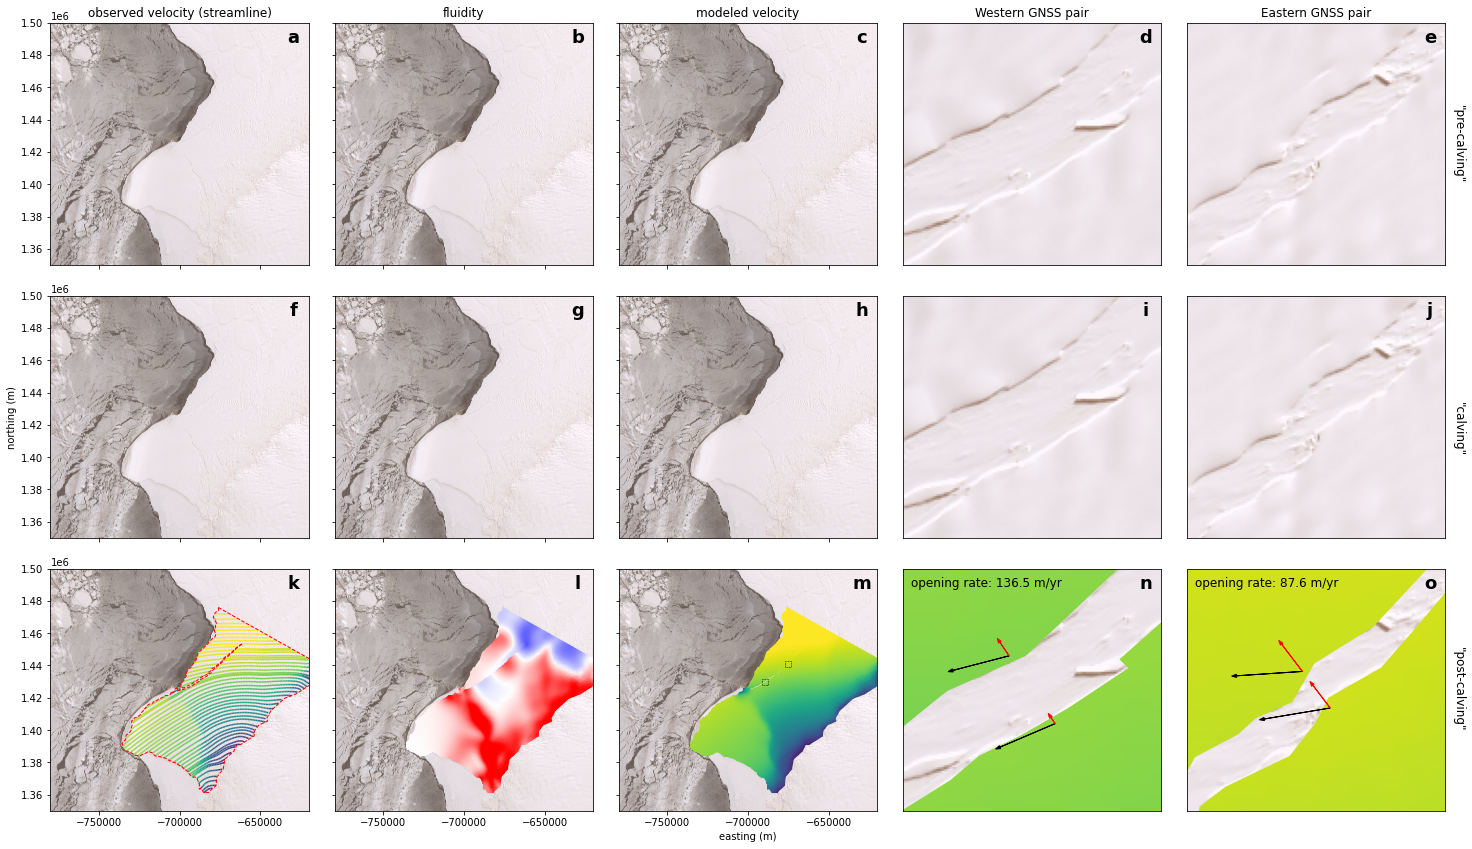

In [34]:
xmin = -780000
xmax = -620000 #160000 wide
ymin = 1350000 
ymax = 1500000 #150000 tall

gr = 0.25

fig,ax=plt.subplots(3,5,figsize=(25,15),gridspec_kw={'wspace': 0.1,'hspace': 0.0125})

#------------------------------------------------------------------------------------
#observed velocity
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax[2][0])

kwargs = {"precision": 1000, "density": 2000}
stream=icepack.plot.streamplot(u0_2021, vmin=0, vmax=1200, axes=ax[2][0], **kwargs)

for feature in outline_2021["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        ax[2][0].plot(xs[:, 0], xs[:, 1], linewidth=1, color='r', linestyle='--')

#ax[2][0].add_patch(Rectangle((-775000,1355000),35000,110000,
#                    edgecolor = 'none',
#                    facecolor = 'white',
#                    alpha = 0.5))

#cbaxes0 = inset_axes(ax[2][0], width="3%", height="40%",loc='lower left',borderpad=2)
#cbar0 = plt.colorbar(stream,cax=cbaxes0, ticks=[0,200,400,600,800,1000,1200])        

#ax[2][0].annotate("m/yr",(-765000,1440000),size=12,ha='left',va='top')

#ax[2][0].plot([-765000,-750000],[1447500,1447500],linewidth=1, color='r', linestyle='--')
     
#ax[2][0].annotate("domain",(-771000,1459000),size=12,ha='left',va='top')
        
#------------------------------------------------------------------------------------
#fluidity        
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax[2][1])

colors_flow = icepack.plot.tripcolor(θ, vmin=-5, vmax=+5, cmap='bwr', axes=ax[2][1])

#ax[2][1].add_patch(Rectangle((-775000,1355000),35000,90000,
#                    edgecolor = 'none',
#                    facecolor = 'white',
#                    alpha = 0.5))

#cbaxes1 = inset_axes(ax[2][1], width="3%", height="40%",loc='lower left',borderpad=2)
#cbar1 = plt.colorbar(colors_flow,cax=cbaxes1, ticks=[-5,-2.5,0,2.5,5])        

#ax[2][1].annotate("m/yr",(-765000,1440000),size=12,ha='left',va='top')        
       
#------------------------------------------------------------------------------------
#modeled velocity
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax[2][2])

colors_vel1 = icepack.plot.tripcolor(u_2021, vmin=0, vmax=1200, axes=ax[2][2])

#ax[2][2].add_patch(Rectangle((-775000,1355000),35000,90000,
#                    edgecolor = 'none',
#                    facecolor = 'white',
#                    alpha = 0.5))

#cbaxes2 = inset_axes(ax[2][2], width="3%", height="40%",loc='lower left',borderpad=2)
#cbar2 = plt.colorbar(stream,cax=cbaxes2, ticks=[0,200,400,600,800,1000,1200])        

#ax[2][2].annotate("m/yr",(-765000,1440000),size=12,ha='left',va='top')

#------------------------------------------------------------------------------------
#western
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax[2][3])

colors_vel2 = icepack.plot.tripcolor(u_2021, vmin=0, vmax=1200, axes=ax[2][3])

#extraction locations        
#ax[2][3].scatter(w_n_x_2021,w_n_y_2021,s=10,c='r')
#ax[2][3].scatter(w_s_x_2021,w_s_y_2021,s=10,c='r')

ax[2][3].arrow(w_n_x_2021,w_n_y_2021,vw_n_2021[0],vw_n_2021[1],head_width=50,color='k',length_includes_head=True)
ax[2][3].arrow(w_s_x_2021,w_s_y_2021,vw_s_2021[0],vw_s_2021[1],head_width=50,color='k',length_includes_head=True)
ax[2][3].arrow(w_n_x_2021,w_n_y_2021,vw_n_2021_perp*math.sin(west_angle),vw_n_2021_perp*math.cos(west_angle),head_width=50,color='r',length_includes_head=True)
ax[2][3].arrow(w_s_x_2021,w_s_y_2021,vw_s_2021_perp*math.sin(west_angle),vw_s_2021_perp*math.cos(west_angle),head_width=50,color='r',length_includes_head=True)

w_ns_x_average = (w_n_x_2021 + w_s_x_2021) / 2
w_ns_y_average = (w_n_y_2021 + w_s_y_2021) / 2

xmin_w = w_ns_x_average - 2000
xmax_w = w_ns_x_average + 2000
ymin_w = w_ns_y_average - 1875
ymax_w = w_ns_y_average + 1875

#ax[2][3].add_patch(Rectangle((xmax_w-5000/40-1500,ymin_w+5000/40),1500,35000/40,
#                    edgecolor = 'none',
#                    facecolor = 'white',
#                    alpha = 0.5))

#ax[2][3].arrow(xmax_w-15000/40,ymin_w+20000/40,-1000,0,head_width=50,color='k')
#ax[2][3].arrow(xmax_w-15000/40,ymin_w+15000/40,-1000,0,head_width=50,color='r')

#ax[2][3].annotate("1000 m/yr",(xmax_w-5000/40-750,ymin_w+25000/40),size=12,ha='center',va='bottom')

ax[2][3].annotate("opening rate: "+str(round(vdiffw_2021,1))+" m/yr",(xmin_w+5000/40,ymax_w-5000/40),size=12,ha='left',va='top')

ax[2][2].plot([xmin_w,xmin_w,xmax_w,xmax_w,xmin_w],\
           [ymin_w,ymax_w,ymax_w,ymin_w,ymin_w],\
           '--',color='k',linewidth=0.5)




#------------------------------------------------------------------------------------
#eastern
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax[2][4])

colors_vel3 = icepack.plot.tripcolor(u_2021, vmin=0, vmax=1200, axes=ax[2][4])

#extraction locations
#ax[2][4].scatter(e_n_x_2021,e_n_y_2021,s=10,c='r')
#ax[2][4].scatter(e_s_x_2021,e_s_y_2021,s=10,c='r')

ax[2][4].arrow(e_n_x_2021,e_n_y_2021,ve_n_2021[0],ve_n_2021[1],head_width=50,color='k',length_includes_head=True)
ax[2][4].arrow(e_s_x_2021,e_s_y_2021,ve_s_2021[0],ve_s_2021[1],head_width=50,color='k',length_includes_head=True)
ax[2][4].arrow(e_n_x_2021,e_n_y_2021,ve_n_2021_perp*math.sin(east_angle),ve_n_2021_perp*math.cos(east_angle),head_width=50,color='r',length_includes_head=True)
ax[2][4].arrow(e_s_x_2021,e_s_y_2021,ve_s_2021_perp*math.sin(east_angle),ve_s_2021_perp*math.cos(east_angle),head_width=50,color='r',length_includes_head=True)

e_ns_x_average = (e_n_x_2021 + e_s_x_2021) / 2
e_ns_y_average = (e_n_y_2021 + e_s_y_2021) / 2

xmin_e = e_ns_x_average - 2000
xmax_e = e_ns_x_average + 2000
ymin_e = e_ns_y_average - 1875
ymax_e = e_ns_y_average + 1875

ax[2][4].annotate("opening rate: "+str(round(vdiffe_2021,1))+" m/yr",(xmin_e+5000/40,ymax_e-5000/40),size=12,ha='left',va='top')

ax[2][2].plot([xmin_e,xmin_e,xmax_e,xmax_e,xmin_e],\
           [ymin_e,ymax_e,ymax_e,ymin_e,ymin_e],\
           '--',color='k',linewidth=0.5)





#------------------------------------------------------------------------------------
#other

show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax[0][0])
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax[0][1])
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax[0][2])
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax[0][3])
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax[0][4])
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax[1][0])
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax[1][1])
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax[1][2])
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax[1][3])
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax[1][4])




ax[0][0].set_title('observed velocity (streamline)')
ax[0][1].set_title('fluidity')
ax[0][2].set_title('modeled velocity')
ax[0][3].set_title('Western GNSS pair')
ax[0][4].set_title('Eastern GNSS pair')

ax[0][0].set_xticklabels([])
ax[0][1].set_xticklabels([])
ax[0][2].set_xticklabels([])
ax[0][1].set_yticklabels([])
ax[0][2].set_yticklabels([])
ax[1][0].set_xticklabels([])
ax[1][1].set_xticklabels([])
ax[1][2].set_xticklabels([])
ax[1][1].set_yticklabels([])
ax[1][2].set_yticklabels([])
ax[2][1].set_yticklabels([])
ax[2][2].set_yticklabels([])
ax[0][0].locator_params(axis='x', nbins=5)
ax[0][1].locator_params(axis='x', nbins=5)
ax[0][2].locator_params(axis='x', nbins=5)
ax[1][0].locator_params(axis='x', nbins=5)
ax[1][1].locator_params(axis='x', nbins=5)
ax[1][2].locator_params(axis='x', nbins=5)
ax[2][0].locator_params(axis='x', nbins=5)
ax[2][1].locator_params(axis='x', nbins=5)
ax[2][2].locator_params(axis='x', nbins=5)

ax[0][3].set_xticks([])
ax[0][3].set_yticks([])
ax[0][4].set_xticks([])
ax[0][4].set_yticks([])
ax[1][3].set_xticks([])
ax[1][3].set_yticks([])
ax[1][4].set_xticks([])
ax[1][4].set_yticks([])
ax[2][3].set_xticks([])
ax[2][3].set_yticks([])
ax[2][4].set_xticks([])
ax[2][4].set_yticks([])
ax[0][3].set_xticklabels([])
ax[0][3].set_yticklabels([])
ax[0][4].set_xticklabels([])
ax[0][4].set_yticklabels([])
ax[1][3].set_xticklabels([])
ax[1][3].set_yticklabels([])
ax[1][4].set_xticklabels([])
ax[1][4].set_yticklabels([])
ax[2][3].set_xticklabels([])
ax[2][3].set_yticklabels([])
ax[2][4].set_xticklabels([])
ax[2][4].set_yticklabels([])

ax[0][0].set_xlim(xmin,xmax)
ax[0][0].set_ylim(ymin,ymax) 
ax[0][1].set_xlim(xmin,xmax)
ax[0][1].set_ylim(ymin,ymax) 
ax[0][2].set_xlim(xmin,xmax)
ax[0][2].set_ylim(ymin,ymax)

ax[1][0].set_xlim(xmin,xmax)
ax[1][0].set_ylim(ymin,ymax) 
ax[1][1].set_xlim(xmin,xmax)
ax[1][1].set_ylim(ymin,ymax) 
ax[1][2].set_xlim(xmin,xmax)
ax[1][2].set_ylim(ymin,ymax)

ax[2][0].set_xlim(xmin,xmax)
ax[2][0].set_ylim(ymin,ymax) 
ax[2][1].set_xlim(xmin,xmax)
ax[2][1].set_ylim(ymin,ymax) 
ax[2][2].set_xlim(xmin,xmax)
ax[2][2].set_ylim(ymin,ymax)

#temp
ax[0][3].set_xlim(xmin_w,xmax_w)
ax[0][3].set_ylim(ymin_w,ymax_w)
ax[0][4].set_xlim(xmin_e,xmax_e)
ax[0][4].set_ylim(ymin_e,ymax_e)
ax[1][3].set_xlim(xmin_w,xmax_w)
ax[1][3].set_ylim(ymin_w,ymax_w)
ax[1][4].set_xlim(xmin_e,xmax_e)
ax[1][4].set_ylim(ymin_e,ymax_e)
ax[2][3].set_xlim(xmin_w,xmax_w)
ax[2][3].set_ylim(ymin_w,ymax_w)
ax[2][4].set_xlim(xmin_e,xmax_e)
ax[2][4].set_ylim(ymin_e,ymax_e)


#ax[0][4].scatter(-620000,1425000,s=10,c='r') #use for positioning
#ax[0][4].text(-618000, 1404000, '"pre-calving"', rotation=-90, fontsize=12) #a
#ax[1][4].scatter(-620000,1425000,s=10,c='r')
#ax[1][4].text(-618000, 1410000, '"calving"', rotation=-90, fontsize=12) #v
#ax[2][4].scatter(-620000,1425000,s=10,c='r')
#ax[2][4].text(-618000, 1402000, '"post-calving"', rotation=-90, fontsize=12) # ca
#ax[2][4].scatter(xmax_e,e_ns_y_average,s=10,c='r') #use for positioning
ax[0][4].text(xmax_e+100, e_ns_y_average-550, '"pre-calving"', rotation=-90, fontsize=12) #a
ax[1][4].text(xmax_e+100, e_ns_y_average-550, '"calving"', rotation=-90, fontsize=12) #v
ax[2][4].text(xmax_e+100, e_ns_y_average-600, '"post-calving"', rotation=-90, fontsize=12) # ca



ax[0][0].annotate("a",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center')
ax[0][1].annotate("b",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center')
ax[0][2].annotate("c",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center')
ax[0][3].annotate("d",(xmax_w-((0.06)*(xmax_w-xmin_w)),ymax_w-(0.06*(ymax_w-ymin_w))),\
             size=18,weight='bold',ha='center',va='center')
ax[0][4].annotate("e",(xmax_e-((0.06)*(xmax_e-xmin_e)),ymax_e-(0.06*(ymax_e-ymin_e))),\
             size=18,weight='bold',ha='center',va='center')

ax[1][0].annotate("f",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center')
ax[1][1].annotate("g",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center')
ax[1][2].annotate("h",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center')
ax[1][3].annotate("i",(xmax_w-((0.06)*(xmax_w-xmin_w)),ymax_w-(0.06*(ymax_w-ymin_w))),\
             size=18,weight='bold',ha='center',va='center')
ax[1][4].annotate("j",(xmax_e-((0.06)*(xmax_e-xmin_e)),ymax_e-(0.06*(ymax_e-ymin_e))),\
             size=18,weight='bold',ha='center',va='center')

ax[2][0].annotate("k",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center')
ax[2][1].annotate("l",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center')
ax[2][2].annotate("m",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center')
ax[2][3].annotate("n",(xmax_w-((0.06)*(xmax_w-xmin_w)),ymax_w-(0.06*(ymax_w-ymin_w))),\
             size=18,weight='bold',ha='center',va='center')
ax[2][4].annotate("o",(xmax_e-((0.06)*(xmax_e-xmin_e)),ymax_e-(0.06*(ymax_e-ymin_e))),\
             size=18,weight='bold',ha='center',va='center')

ax[1][0].set_ylabel("northing (m)") 
ax[2][2].set_xlabel("easting (m)")

#plt.tight_layout()

output = 'fig07_model_p3.png'
plt.savefig(output, dpi=300, bbox_inches='tight')

plt.show()